**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)


### Поключим библиотеки

In [1]:
import numpy as np
import pandas as pd
import random

import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import catboost as catb

Зададим параметры для отображения графиков и оключим предупреждения Anaconda

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

rcParams['figure.figsize'] = 8, 5

import warnings
warnings.simplefilter('ignore')

In [3]:
def graph_scatter(x_label, y_label):
    fig, ax = plt.subplots(figsize=(3, 3))
    
    ax.scatter(x=df[x_label], y=df[y_label])
    ax.set_title('Graph')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    plt.show()
    
def graph_crosstab(x_label, y_label):
    pd.crosstab(df[x_label],df[y_label]).plot(kind='bar')
    plt.title(y_label + ' Frequency for ' + x_label)
    plt.xlabel(x_label)
    plt.ylabel('Frequency of ' + y_label)
    
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.plot(thresholds, [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,], label='0.5', linewidth=1)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt.show()
    
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (9, len(feature_importances) * 0.255))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [4]:
def my_split(X, y):
    X_x, X_test, y_y, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42, stratify=y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_x, y_y, test_size=0.2, shuffle=True, random_state=42, stratify=y_y)
    return X_test, y_test, X_train, X_valid, y_train, y_valid

In [5]:
def evaluate_preds(train_true_values, train_pred_values, valid_true_values, valid_pred_values):
    print("Train f1:\t" + str(round(f1_score(train_true_values, train_pred_values, zero_division=1), 3)))
    print("Valid/TEST f1:\t" + str(round(f1_score(valid_true_values, valid_pred_values, zero_division=1), 3)))

In [6]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    

### Пропишем путь и загрузим данные

In [7]:
TRAIN_DATASET_PATH = './course_project/course_project_train.csv'
TEST_DATASET_PATH = './course_project/course_project_test.csv'

df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

#### Объединим тренировочную и тестовую выборки для последующей обработки данных

In [8]:
df = pd.concat([df_train, df_test], ignore_index = True)
df.head(2)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0.0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1.0


#### Заполним пропуски и преобразуем типы данных

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                10000 non-null  object 
 1   Annual Income                 7930 non-null   float64
 2   Years in current job          9543 non-null   object 
 3   Tax Liens                     10000 non-null  float64
 4   Number of Open Accounts       10000 non-null  float64
 5   Years of Credit History       10000 non-null  float64
 6   Maximum Open Credit           10000 non-null  float64
 7   Number of Credit Problems     10000 non-null  float64
 8   Months since last delinquent  4561 non-null   float64
 9   Bankruptcies                  9983 non-null   float64
 10  Purpose                       10000 non-null  object 
 11  Term                          10000 non-null  object 
 12  Current Loan Amount           10000 non-null  float64
 13  Cu

In [10]:
df.isna().sum()

Home Ownership                     0
Annual Income                   2070
Years in current job             457
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    5439
Bankruptcies                      17
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    2070
Credit Default                  2500
dtype: int64

Построим гистограммы признаков. Как мы видим __Credit Score__ и __Current Loan Amount__ имеют достаточно большое количество обособленных экземпляров.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B56D730>,
      dtype=object)

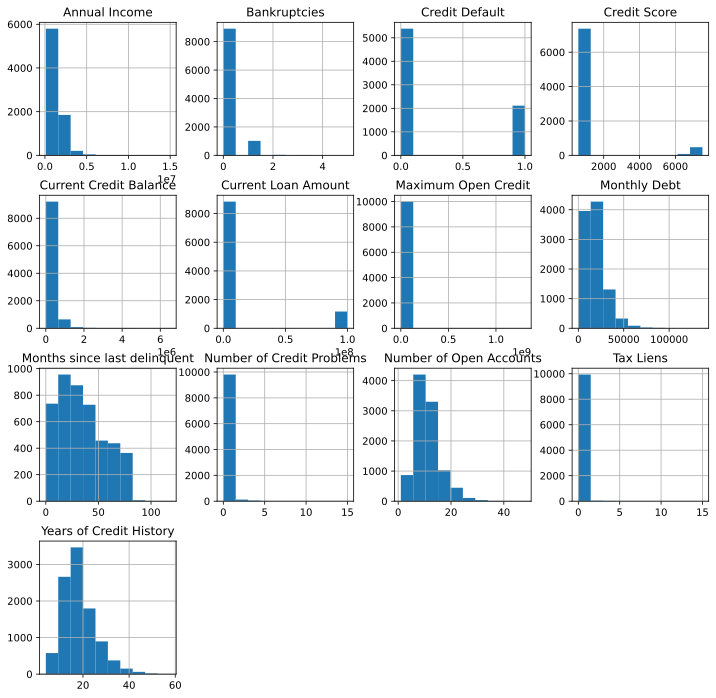

In [11]:
cat_feature = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
num_feature = [el for el in df.columns if el not in cat_feature]

df[num_feature].hist(figsize=(12,12))

In [12]:
df[df['Current Loan Amount'] > 1000000].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,1.167000e+03,1167.000000,1167.00000,1167.000000,1.167000e+03,1167.000000,502.000000,1164.000000,1167.0,1.167000e+03,1167.000000,1167.000000,870.0
mean,1.408451e+06,0.025707,11.22108,18.377035,8.085650e+05,0.152528,34.575697,0.109107,99999999.0,3.026889e+05,18039.287061,729.736075,0.0
std,8.590412e+05,0.254005,4.83013,6.936883,1.891140e+06,0.448793,21.196760,0.330641,0.0,3.696304e+05,12070.163959,22.202535,0.0
min,1.065330e+05,0.000000,2.00000,4.800000,0.000000e+00,0.000000,0.000000,0.000000,99999999.0,0.000000e+00,0.000000,587.000000,0.0
25%,8.723660e+05,0.000000,8.00000,13.700000,2.984190e+05,0.000000,18.000000,0.000000,99999999.0,1.119480e+05,9494.500000,726.000000,0.0
50%,1.239826e+06,0.000000,11.00000,17.000000,5.207400e+05,0.000000,32.000000,0.000000,99999999.0,2.139400e+05,15640.000000,737.000000,0.0
75%,1.720260e+06,0.000000,14.00000,21.750000,8.543040e+05,0.000000,50.000000,0.000000,99999999.0,3.672320e+05,23977.500000,744.000000,0.0
max,8.758449e+06,6.000000,34.00000,50.900000,4.092389e+07,6.000000,81.000000,3.000000,99999999.0,4.304051e+06,94674.000000,751.000000,0.0


In [13]:
df[df['Credit Score'] > 1000].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.600000e+02,560.000000,560.000000,560.000000,5.600000e+02,560.000000,262.000000,557.000000,560.000000,5.600000e+02,560.000000,560.000000,400.0
mean,1.240761e+06,0.033929,11.378571,18.014107,5.787748e+05,0.157143,33.908397,0.102334,329316.153571,2.837622e+05,18417.741071,7112.482143,1.0
std,7.322374e+05,0.247908,5.032585,7.338723,5.093109e+05,0.497168,21.985175,0.372545,190854.595191,2.339910e+05,11206.253926,304.097391,0.0
min,2.060170e+05,0.000000,2.000000,5.500000,1.113200e+04,0.000000,0.000000,0.000000,29876.000000,5.700000e+01,57.000000,6060.000000,1.0
25%,7.664220e+05,0.000000,8.000000,12.900000,2.857910e+05,0.000000,17.000000,0.000000,188732.500000,1.307865e+05,10450.500000,6960.000000,1.0
50%,1.054510e+06,0.000000,11.000000,16.500000,4.579520e+05,0.000000,31.000000,0.000000,270116.000000,2.244090e+05,16404.500000,7190.000000,1.0
75%,1.520342e+06,0.000000,14.000000,21.900000,7.144060e+05,0.000000,48.000000,0.000000,444224.000000,3.548772e+05,24212.250000,7340.000000,1.0
max,8.200229e+06,3.000000,42.000000,49.300000,6.639358e+06,5.000000,82.000000,5.000000,788634.000000,1.575879e+06,73412.000000,7510.000000,1.0


Не будем никаким образом корректировать эти значения.
Как видно "Credit Score" находится в диапазоне [6060, 7510] все остальные наблюдения из данной выборки находятся в диапазоне [585, 751]. Кажется что это выбросы, которые можно скорректировать поделив на 10, но как видно целевая переменная "Credit Default" везде принимает значение 1, чего не скажешь о значениях целевой переменной при значениях "Credit Score" [606, 751]

Значение "Current Loan Amount"=99999999.0 тоже выглядит неправдоподобным, но т.к. целевая переменная также принимает только значение 0 и часть признаков имеет стандартное отклонение превышающее в разы свое среднее, не понятно каким образом изменить это значение. 

Скорректируем признак **Bankruptcies**.

Посмотрим возможные варианты данного признака и значения основных статистик для наблюдений с незаполненным значением признака, построим график зависимости признаков __Bankruptcies__ и __Number of Credit Problems__

In [14]:
df.Bankruptcies.value_counts()

0.0    8912
1.0    1020
2.0      36
3.0      10
4.0       3
5.0       2
Name: Bankruptcies, dtype: int64

In [15]:
df[df.Bankruptcies.isnull()].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,1.400000e+01,17.0,17.000000,17.000000,1.700000e+01,17.0,17.000000,0.0,1.700000e+01,17.000000,17.000000,14.000000,14.000000
mean,8.649492e+05,0.0,10.117647,20.041176,7.208313e+05,0.0,9.941176,NaN,1.782959e+07,185754.058824,6252.117647,2126.214286,0.285714
std,8.147604e+05,0.0,5.588854,8.895438,8.195980e+05,0.0,24.923560,NaN,3.920854e+07,210611.664166,6880.559142,2771.068419,0.468807
min,2.335670e+05,0.0,2.000000,11.700000,0.000000e+00,0.0,0.000000,NaN,1.124200e+04,0.000000,0.000000,674.000000,0.000000
25%,3.288852e+05,0.0,6.000000,13.600000,3.812600e+04,0.0,0.000000,NaN,9.262000e+04,18373.000000,1243.000000,732.500000,0.000000
50%,6.017395e+05,0.0,9.000000,18.300000,5.751240e+05,0.0,0.000000,NaN,2.101660e+05,126331.000000,3488.000000,744.500000,0.000000
75%,8.514375e+05,0.0,14.000000,20.300000,7.928360e+05,0.0,0.000000,NaN,5.289680e+05,236816.000000,9669.000000,749.500000,0.750000
max,2.914695e+06,0.0,20.000000,43.100000,2.600840e+06,0.0,77.000000,NaN,1.000000e+08,625157.000000,23746.000000,7490.000000,1.000000


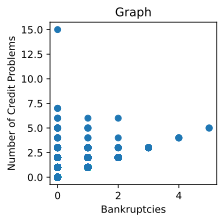

In [16]:
graph_scatter('Bankruptcies', 'Number of Credit Problems')  

Из графика можно сделать предположение, что банкротство не возникает в ситуациях, когда не было проблем с кредитом. Исходя из этого предположения заполним пропуски.

In [17]:
df.loc[df.Bankruptcies.isnull(), 'Bankruptcies'] = 0

Заполним пропуски категориального признака __Years in current job__

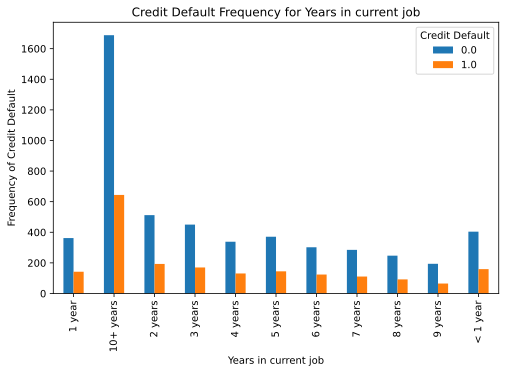

In [18]:
graph_crosstab('Years in current job', 'Credit Default')

Как мы видим соотношение экземпляров с значение целевой переменной 0 и 1 в каждом классе признака "Years in current job" примерно одинаковое, поэтому сократим количество категорий и заполним пропуски новым значением.

In [19]:
df['Years in current job'] = df['Years in current job'].map({'< 1 year':'1minus year', 
                                       '1 year':'1plus year', 
                                       '2 year':'1plus year',
                                       '3 year':'1plus year',
                                       '4 year':'1plus year',
                                       '5 year':'1plus year',
                                       '6 year':'1plus year',
                                       '7 year':'1plus year',
                                       '8 year':'1plus year',
                                       '9 year':'1plus year',
                                       '10+ years':'10plus year'})

mask = df['Years in current job'].isnull()
df.loc[mask, 'Years in current job'] = 'x year'

Скорректируем значение __Current Credit Balance__

In [20]:
df['Current Credit Balance'].describe()

count    1.000000e+04
mean     2.914741e+05
std      3.339979e+05
min      0.000000e+00
25%      1.132258e+05
50%      2.090190e+05
75%      3.619500e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

In [21]:
mask = (df['Current Credit Balance'] == 0) & (df['Monthly Debt'] == 0) & (df['Credit Score'].isnull())
df.drop(df[mask].index, inplace=True)

In [22]:
mask = (df['Credit Default'].notnull()) & (df['Annual Income'].isnull()) & (df['Maximum Open Credit']==0) & (df['Credit Score'].isnull())
df[mask]
df.drop(df[mask].index, inplace=True)

Скорректируем признак __Credit Score__ и __Annual Income__

In [23]:
df.loc[df['Credit Score'].isnull(), 'Credit Score'] = df['Credit Score'].median()

df.loc[df['Annual Income'].isnull(), 'Annual Income'] = df['Annual Income'].median()

Скорректируем признак __Months since last delinquent__

In [24]:
mask = df['Months since last delinquent'].isnull()

df.loc[mask, 'Months since last delinquent'] = 0

__Построим матрицу корреляции__ для нахождения признаков максимально коррелирующих с целевой переменной.

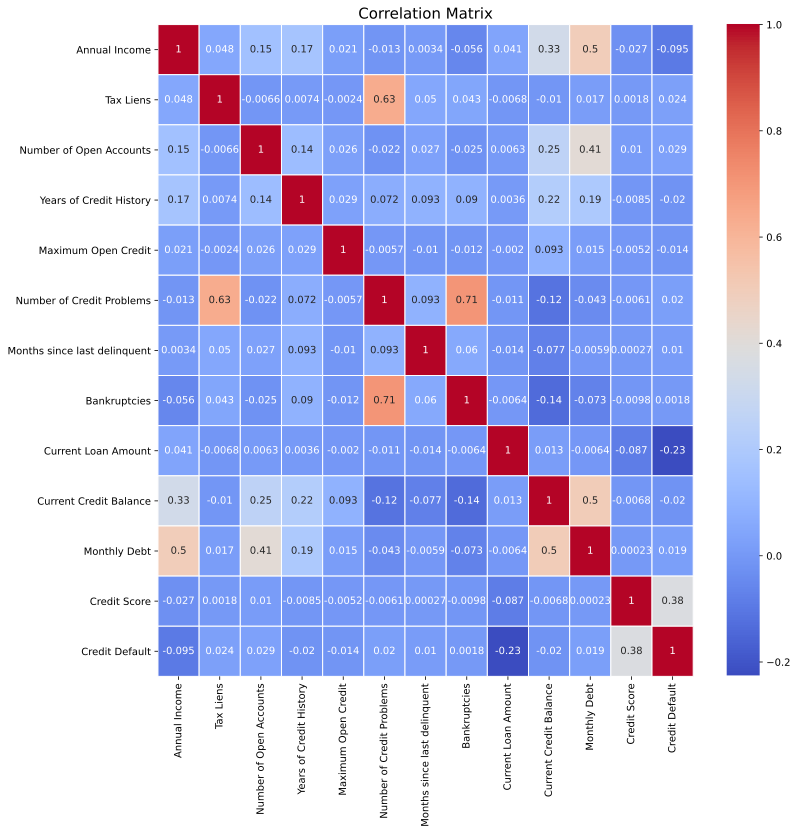

In [25]:
corr_matrix = df.corr()

fig, axes = plt.subplots(1, 1, figsize=(12, 12))
axes.set_title("Correlation Matrix", fontsize=15)
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, linewidths=1)

Как мы видим __Credit Score__ очень важен, но не известно как определяется его значение, поэтому не будем строить новые признаки на нем. Построим новые признаки, используя __Annual Income__ и __Current Loan Amount__

In [26]:
df['new_1'] = df['Current Loan Amount'] / df['Annual Income']
df['new_2'] = df['Monthly Debt'] / df['Annual Income']

Сократим количество катагориальных признаков:

In [27]:
df['Purpose'] = df['Purpose'].map({'business loan':'business', 
                                       'buy a car':'relax', 
                                       'buy house' : 'relax',
                                       'debt consolidation' : 'debt consolidation',
                                       'educational expenses' : 'relax',
                                       'home improvements' : 'relax',
                                       'major purchase' : 'relax',
                                       'medical bills' : 'other',
                                       'moving' : 'relax',
                                       'other' : 'other',
                                       'renewable energy' : 'business',
                                       'small business' : 'business',
                                      'take a trip' : 'relax',
                                      'vacation' : 'relax',
                                      'wedding' : 'relax'})

In [28]:
mask = df['Home Ownership'] == 'Have Mortgage'
df.loc[mask, 'Home Ownership'] = 'Home Mortgage'

In [29]:
for colname in cat_feature:
    df[colname] = pd.Categorical(df[colname])

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9978 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                9978 non-null   category
 1   Annual Income                 9978 non-null   float64 
 2   Years in current job          9978 non-null   category
 3   Tax Liens                     9978 non-null   float64 
 4   Number of Open Accounts       9978 non-null   float64 
 5   Years of Credit History       9978 non-null   float64 
 6   Maximum Open Credit           9978 non-null   float64 
 7   Number of Credit Problems     9978 non-null   float64 
 8   Months since last delinquent  9978 non-null   float64 
 9   Bankruptcies                  9978 non-null   float64 
 10  Purpose                       9978 non-null   category
 11  Term                          9978 non-null   category
 12  Current Loan Amount           9978 non-null   fl

### Перевод категориальных переменных и проверка отсутствия пропусков

In [31]:
for cat_colname in df.select_dtypes(include='category').columns:
    df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)

In [32]:
df.select_dtypes(include='category').columns

Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='object')

In [33]:
df.isna().sum()

Home Ownership                         0
Annual Income                          0
Years in current job                   0
Tax Liens                              0
Number of Open Accounts                0
Years of Credit History                0
Maximum Open Credit                    0
Number of Credit Problems              0
Months since last delinquent           0
Bankruptcies                           0
Purpose                                0
Term                                   0
Current Loan Amount                    0
Current Credit Balance                 0
Monthly Debt                           0
Credit Score                           0
Credit Default                      2500
new_1                                  0
new_2                                  0
Home Ownership_Home Mortgage           0
Home Ownership_Own Home                0
Home Ownership_Rent                    0
Years in current job_10plus year       0
Years in current job_1minus year       0
Years in current

In [34]:
for col in df.select_dtypes(include='category').columns:
    df = df.drop(col, axis = 1)

### Разбиение на тренировочный, валидационный и тестовый датасеты

In [35]:
mask = df['Credit Default'].notnull()
X = pd.DataFrame(df[mask])
y = pd.DataFrame(X['Credit Default'])

X = X.drop('Credit Default', axis = 1)

df_test = pd.DataFrame(df[~mask])

In [36]:
df_test.head(2)

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Years in current job_10plus year,Years in current job_1minus year,Years in current job_1plus year,Years in current job_x year,Purpose_business,Purpose_debt consolidation,Purpose_other,Purpose_relax,Term_Long Term,Term_Short Term
7500,1168813.5,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,162470.0,105906.0,...,0,0,0,1,0,1,0,0,0,1
7501,231838.0,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,78298.0,46037.0,...,0,0,1,0,0,0,0,1,0,1


In [37]:
X_test, y_test, X_train, X_valid, y_train, y_valid = my_split(X, y)
X_train.shape

(5384, 27)

## КЛАССИФИКАЦИЯ

#### CatBoost_Classifier

In [38]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 2.2], silent=True, random_state=21)
model_catb.fit(X_train, y_train)


In [39]:
y_train_catb = model_catb.predict(X_train)
y_valid_catb = model_catb.predict(X_valid)

evaluate_preds(y_train, y_train_catb, y_valid, y_valid_catb)
get_classification_report(y_train, y_train_catb, y_valid, y_valid_catb)

Train f1:	0.848
Valid/TEST f1:	0.551
TRAIN

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      3866
         1.0       0.83      0.87      0.85      1518

    accuracy                           0.91      5384
   macro avg       0.89      0.90      0.89      5384
weighted avg       0.91      0.91      0.91      5384

TEST

              precision    recall  f1-score   support

         0.0       0.83      0.82      0.82       967
         1.0       0.54      0.56      0.55       379

    accuracy                           0.74      1346
   macro avg       0.68      0.69      0.69      1346
weighted avg       0.75      0.74      0.74      1346



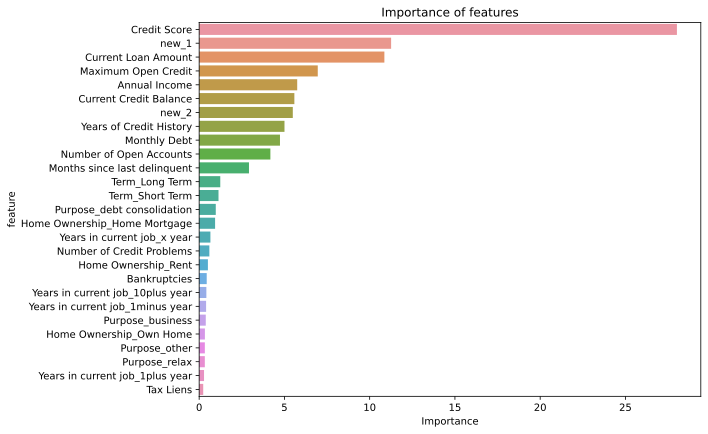

In [40]:
important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=15)

Как видно из графика выше в итоговой моделе можно оставить все признаки и обучить ее с применением гиперпараметров.

# Построение итоговой модели

In [41]:
model = catb.CatBoostClassifier(class_weights=[1, 2.25], silent=True, random_state=21, iterations = 90, depth = 2)
model.fit(X_train, y_train)

In [42]:
y_train_catb = model.predict(X_train)
y_valid_catb = model.predict(X_valid)

y_valid_catb_probs = model.predict_proba(X_valid)

evaluate_preds(y_train, y_train_catb, y_valid, y_valid_catb)
get_classification_report(y_train, y_train_catb, y_valid, y_valid_catb)

Train f1:	0.586
Valid/TEST f1:	0.563
TRAIN

              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82      3866
         1.0       0.55      0.62      0.59      1518

    accuracy                           0.75      5384
   macro avg       0.70      0.71      0.70      5384
weighted avg       0.76      0.75      0.76      5384

TEST

              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81       967
         1.0       0.52      0.61      0.56       379

    accuracy                           0.73      1346
   macro avg       0.68      0.70      0.68      1346
weighted avg       0.75      0.73      0.74      1346



In [43]:
cv_score = cross_val_score(
    model,
    X,
    y,
    scoring='f1',
    cv=KFold(n_splits=5, shuffle=True, random_state=1)
)
cv_score

array([0.55518395, 0.51869159, 0.57704918, 0.54094828, 0.53290183])

In [44]:
cv_score.mean()

0.5449549650671973

In [45]:
y_train_catb = model.predict(X_train)
y_test_catb = model.predict(X_test)

evaluate_preds(y_train, y_train_catb, y_test, y_test_catb)
get_classification_report(y_train, y_train_catb, y_test, y_test_catb)

Train f1:	0.586
Valid/TEST f1:	0.551
TRAIN

              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82      3866
         1.0       0.55      0.62      0.59      1518

    accuracy                           0.75      5384
   macro avg       0.70      0.71      0.70      5384
weighted avg       0.76      0.75      0.76      5384

TEST

              precision    recall  f1-score   support

         0.0       0.83      0.80      0.81       537
         1.0       0.53      0.58      0.55       211

    accuracy                           0.73       748
   macro avg       0.68      0.69      0.68       748
weighted avg       0.74      0.73      0.74       748



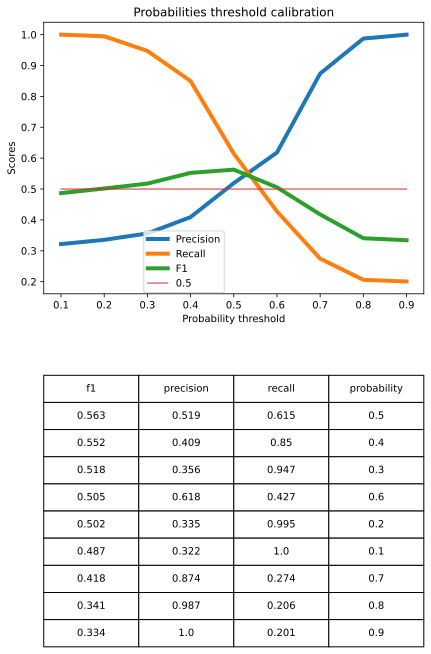

In [46]:
show_proba_calibration_plots(y_valid_catb_probs[:, 1], y_valid)

# Прогноз итоговой модели

In [47]:
predict_data = model.predict(df_test).astype(int)
predict_data

y_test = pd.DataFrame({'Credit Default' : predict_data})
y_test

,Credit Default
0,0
1,1
2,1
3,0
4,0
...,...
2495,0
2496,1
2497,0
2498,0


In [48]:
y_test.to_csv('EIKuznetsova_predictions.csv', index=None)